# Data Class

In [1]:
import random


class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"


class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()

    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else:  #score of 4 or 5
            return Sentiment.POSITIVE


class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews

    def get_text(self):
        return [x.text for x in self.reviews]

    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]

    def evenly_distribution(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))

        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)



# Load Data 

In [2]:
import json

file_name = r'ignore/dataBooks_5_new.json'

reviews = []
with open(file_name) as f:
    for line in f:
        review = json.loads(line)
        #         print(review['reviewText'])
        #         print(review['overall'])
        reviews.append(Review(review['reviewText'], review['overall']))

reviews[5].text


"Boy, what a whiney person Adrianna is, demanding too. Muscling Adam into going to a party just to make her happy. Each has lusted after the other for 4years. Surprise, surprise she gets them lost in the woods and he has no backbone to stand up to her. I will read the next story, but I'm not sold yet.  Only time will tell."

# Prep Data

In [3]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(reviews, test_size=0.33, random_state=42)

train_container = ReviewContainer(training)
test_container = ReviewContainer(test)


In [4]:
train_container.evenly_distribution()
train_x = train_container.get_text()
train_y = train_container.get_sentiment()

test_container.evenly_distribution()
test_x = test_container.get_text()
test_y = test_container.get_sentiment()

print(train_y.count(Sentiment.POSITIVE))
print(train_y.count(Sentiment.NEGATIVE))

21779
21779


## Bag of words vectorization 

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer()

train_x_vectors = vectorizer.fit_transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

print(train_x[0])
print(train_x_vectors[0].toarray())



I read this for my book club and I don't know why the leader even picked it. There are times when the writer says that some things should stay private, so he doesn't give details and leaves you hanging. This was the most disappointing book I've read in ages. When it ended, I said out loud to myself...WHAT???? It was finished and I didn't know the point of the story.
[[0. 0. 0. ... 0. 0. 0.]]


# Classification

### Linear SVM

In [6]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, train_y)

test_x[0]

clf_svm.predict(test_x_vectors[0])


array(['POSITIVE'], dtype='<U8')

### Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

clf_dec.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

### Naive Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = DecisionTreeClassifier()
clf_gnb.fit(train_x_vectors, train_y)

clf_gnb.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

### Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()

clf_log.fit(train_x_vectors, train_y)

clf_log.predict(test_x_vectors[0])

C:\Users\rohit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['POSITIVE'], dtype='<U8')

# Evaluation

In [25]:
# Mean Accuracy
mean_acc_svm = clf_svm.score(test_x_vectors, test_y)
mean_acc_dec = clf_dec.score(test_x_vectors, test_y)
mean_acc_gnb = clf_gnb.score(test_x_vectors, test_y)
mean_acc_log = clf_log.score(test_x_vectors, test_y)

print(mean_acc_svm)
print(mean_acc_dec)
print(mean_acc_gnb)
print(mean_acc_log)

0.904173685195583
0.7364308440950776
0.7407355418304323
0.902676399026764


In [30]:
import pandas as pd
models = [('Linear SVM', mean_acc_svm), ('Decision Tree', mean_acc_dec), ('Naive Bayes', mean_acc_gnb), ('Logistic Regression', mean_acc_log)]
df_models = pd.DataFrame(data=models, columns=['Model', 'Mean Accuracy'])
df_models

,Model,Mean Accuracy
0,Linear SVM,0.904174
1,Decision Tree,0.736431
2,Naive Bayes,0.740736
3,Logistic Regression,0.902676


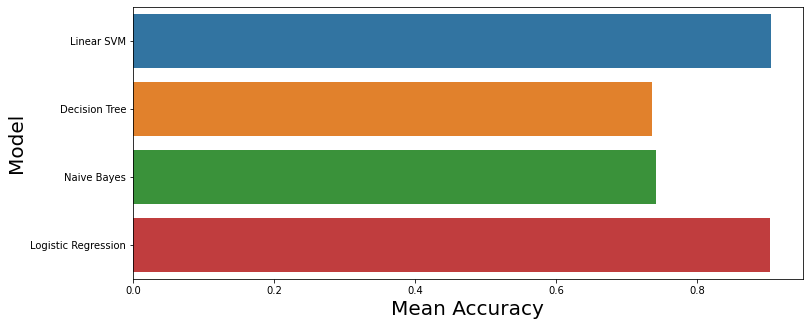

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axe = plt.subplots(1,1, figsize=(12,5))
sns.barplot(y='Model', x='Mean Accuracy', data=df_models, ax = axe)
axe.set_ylabel('Model', size=20)
axe.set_xlabel('Mean Accuracy', size=20)

plt.show()

## Saving Model and Vectorizer

In [19]:
import pickle

with open(r'./models/sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf_svm, f)

with open(r'./models/vectorizer.pkl', 'wb') as g:
    pickle.dump(vectorizer, g)

### load model

In [20]:
import pickle

with open(r'./models/sentiment_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

with open(r'./models/vectorizer.pkl', 'rb') as g:
    loaded_vectorizer = pickle.load(g)

## running test cases

In [39]:
t1 = ['there was nothing interesting in the book, waste of time', 'absolute disgusting', 'loved it', 'amazing content', 'not a good one']
test_case = loaded_vectorizer.transform(t1)
result = loaded_clf.predict(test_case)

print(result)

['NEGATIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE' 'NEGATIVE']
